Task : Transliteration   

**sequence to sequence generation**  

processing xml files to get data.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import random

from IPython.display import clear_output

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Data Management

xml files - one training(13937), one testing(1000).

xml - heirarchical data format.  
top - root node  
in that elements.. 

id - unique id  
sorce name  
target name

### Alphabets Setup

In [4]:
# index for characters
# for one hot, etc.. 

# transliteration - not specific to uppper, lower case.
# all converted to one case.. here upper case.

eng_alphabets = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
pad_char = '-PAD-'

# dictionary with key = alphabet, value = index
eng_alpha2index = {pad_char: 0}
for index, alpha in enumerate(eng_alphabets):
    eng_alpha2index[alpha] = index+1

print(eng_alpha2index)

{'-PAD-': 0, 'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'H': 8, 'I': 9, 'J': 10, 'K': 11, 'L': 12, 'M': 13, 'N': 14, 'O': 15, 'P': 16, 'Q': 17, 'R': 18, 'S': 19, 'T': 20, 'U': 21, 'V': 22, 'W': 23, 'X': 24, 'Y': 25, 'Z': 26}


In [5]:
# Hindi Unicode Hex Range is 2304:2432. Source: https://en.wikipedia.org/wiki/Devanagari_(Unicode_block)
# unicode (binary for letters..) for hindi letters.
# adayaalams - different character.. 
# aksharam with adayalm will be thus 2 characters.

hindi_alphabets = [chr(alpha) for alpha in range(2304, 2432)]
hindi_alphabet_size = len(hindi_alphabets)

# dictionary with key = alphabet, value = index
hindi_alpha2index = {pad_char: 0}
for index, alpha in enumerate(hindi_alphabets):
    hindi_alpha2index[alpha] = index+1

print(hindi_alpha2index)

{'-PAD-': 0, 'ऀ': 1, 'ँ': 2, 'ं': 3, 'ः': 4, 'ऄ': 5, 'अ': 6, 'आ': 7, 'इ': 8, 'ई': 9, 'उ': 10, 'ऊ': 11, 'ऋ': 12, 'ऌ': 13, 'ऍ': 14, 'ऎ': 15, 'ए': 16, 'ऐ': 17, 'ऑ': 18, 'ऒ': 19, 'ओ': 20, 'औ': 21, 'क': 22, 'ख': 23, 'ग': 24, 'घ': 25, 'ङ': 26, 'च': 27, 'छ': 28, 'ज': 29, 'झ': 30, 'ञ': 31, 'ट': 32, 'ठ': 33, 'ड': 34, 'ढ': 35, 'ण': 36, 'त': 37, 'थ': 38, 'द': 39, 'ध': 40, 'न': 41, 'ऩ': 42, 'प': 43, 'फ': 44, 'ब': 45, 'भ': 46, 'म': 47, 'य': 48, 'र': 49, 'ऱ': 50, 'ल': 51, 'ळ': 52, 'ऴ': 53, 'व': 54, 'श': 55, 'ष': 56, 'स': 57, 'ह': 58, 'ऺ': 59, 'ऻ': 60, '़': 61, 'ऽ': 62, 'ा': 63, 'ि': 64, 'ी': 65, 'ु': 66, 'ू': 67, 'ृ': 68, 'ॄ': 69, 'ॅ': 70, 'ॆ': 71, 'े': 72, 'ै': 73, 'ॉ': 74, 'ॊ': 75, 'ो': 76, 'ौ': 77, '्': 78, 'ॎ': 79, 'ॏ': 80, 'ॐ': 81, '॑': 82, '॒': 83, '॓': 84, '॔': 85, 'ॕ': 86, 'ॖ': 87, 'ॗ': 88, 'क़': 89, 'ख़': 90, 'ग़': 91, 'ज़': 92, 'ड़': 93, 'ढ़': 94, 'फ़': 95, 'य़': 96, 'ॠ': 97, 'ॡ': 98, 'ॢ': 99, 'ॣ': 100, '।': 101, '॥': 102, '०': 103, '१': 104, '२': 105, '३': 106, '४': 107, '५': 108, '६': 109, '७': 

### Helper functions for data pre-processing

In [6]:
import re # regex
non_eng_letters_regex = re.compile('[^a-zA-Z ]')

# Remove all non-English letters
def cleanEnglishVocab(line):
    line = line.replace('-', ' ').replace(',', ' ').upper()
    line = non_eng_letters_regex.sub('', line)
    return line.split()

# Remove all non-Hindi letters
# can do regex effectively in hindi.
# so loop and do manually
def cleanHindiVocab(line):
    line = line.replace('-', ' ').replace(',', ' ')
    cleaned_line = ''
    for char in line:
        if char in hindi_alpha2index or char == ' ':
            cleaned_line += char
    return cleaned_line.split()

### Dataset Loading

in a DL project - there is a component of software engg. To process raw data.. and bring it into a form that can be passed to a network. (**pre-processing**)

# Dataloader class
- inherinting from torch.utils.data.Dataset class

In [7]:
from torch.utils.data import Dataset
import xml.etree.ElementTree as ET

# extending dataset class of pytorch 
# process a given data.. and give workable 'dataset'
class TransliterationDataLoader(Dataset):
    def __init__(self, filename):
        # read file - corresponding eng, hindi words
        self.eng_words, self.hindi_words = self.readXmlDataset(filename, cleanHindiVocab)
        
        # shuffled indices
        self.shuffle_indices = list(range(len(self.eng_words))) # list of indices.
        random.shuffle(self.shuffle_indices) # list of shuffled indices.
        
        self.shuffle_start_index = 0  # maintain this pointer - start from this give next b points.
        # update this pointer.
        # shuffle everything - then give batch by batch using a pointer.
        
    def __len__(self):
        return len(self.eng_words)
    
    # magic function that allows for square bracket indexing
    def __getitem__(self, idx): # word pair at index.
        return self.eng_words[idx], self.hindi_words[idx]
    
    def readXmlDataset(self, filename, lang_vocab_cleaner):

        # parse file
        transliterationCorpus = ET.parse(filename).getroot() # gives root.
        # here root: "TransliterationCorpus" (first tag)
        # all rest are childrens
        lang1_words = []
        lang2_words = []

        # root - iteratable 
        # like a nested list - (heirarchical)
        # can iterate through the children
        for line in transliterationCorpus:
            wordlist1 = cleanEnglishVocab(line[0].text)
            wordlist2 = lang_vocab_cleaner(line[1].text)

            # Skip noisy data
            if len(wordlist1) != len(wordlist2): # words (not letters)
                print('Skipping: ', line[0].text, ' - ', line[1].text)
                continue

            for word in wordlist1:
                lang1_words.append(word)
            for word in wordlist2:
                lang2_words.append(word)

        return lang1_words, lang2_words
    
    def get_random_sample(self): # random datapoint
    # using get_item with random index.
        return self.__getitem__(np.random.randint(len(self.eng_words)))
    
    # get a batch of size=batch_size from that array.
    def get_batch_from_array(self, batch_size, array):
        end = self.shuffle_start_index + batch_size
        batch = []

        # if overflow - loop to first - rest of the points from the beginning.
        if end >= len(self.eng_words):
            batch = [array[i] for i in self.shuffle_indices[0:end%len(self.eng_words)]]
            end = len(self.eng_words)
        return batch + [array[i] for i in self.shuffle_indices[self.shuffle_start_index : end]]
    
    # both arrays - batch.
    def get_batch(self, batch_size, postprocess = True):
        eng_batch = self.get_batch_from_array(batch_size, self.eng_words)
        hindi_batch = self.get_batch_from_array(batch_size, self.hindi_words)
        self.shuffle_start_index += batch_size + 1 #update index.
        
        # Reshuffle if 1 epoch is complete
        if self.shuffle_start_index >= len(self.eng_words):
            random.shuffle(self.shuffle_indices)
            self.shuffle_start_index = 0
            
        return eng_batch, hindi_batch



# this is one way to implement a dataloader(not the most efficient way)
# get item, get batch, .. such stuff which can be used w/o having to worry about whats in.
# encapsulating the dataloading part.

In [8]:
train_data = TransliterationDataLoader('NEWS2012-Training-EnHi-13937.xml')
test_data = TransliterationDataLoader('NEWS2012-Ref-EnHi-1000.xml')

Skipping:  BARHARWA JUNCTION  -  बरहरवा
Skipping:  STATE BNK TR  -  स्टेट बैंक ऑफ त्रावणकोर
Skipping:  SOUTH ARLINGTON CHURCH OF CHRIST  -  साउथ अर्लिंग्टन
Skipping:  KING EDWARD VII  -  किंग एडवर्ड
Skipping:  DIBANG VALLEY  -  दिबंगवैली
Skipping:  ORDER OF VASA  -  ऑडर ऑफ़ द वासा
Skipping:  AZAMNAGAR ROAD  -  आज़मनगर
Skipping:  CAPE TOWN  -  केपटाउन
Skipping:  NEW ZEALAND  -  न्यूज़ीलैंड
Skipping:  SEA OF THE HEBRIDES  -  सी ऑफ हरब्रिड्‍स
Skipping:  RAMCOIND  -  राम्को इंड
Skipping:  KELVINGROVE ART GALLERY AND MUSEUM  -  केल्व‍िनग्रोव आर्ट एण्ड म्युज़ियम
Skipping:  AUSTRALIAN NATIONAL UNIVERSITY  -  ऑस्ट्रेलियननेशनल यूनिवर्सिटी
Skipping:  JAHAN AARA  -  जहाँआरा
Skipping:  NAVABHARAT FERRO ALLOYS  -  नव भारत फ़ैरो अलॉय
Skipping:  RAMA LINGESHWARA  -  रामालिंगेश्वर
Skipping:  FAKHRUN NISA  -  फखरुन्निसा
Skipping:  REDIFF.COM INDIA LIMITED  -  रेडिफ़ डॉट कॉम इंडिया लिमिटेड
Skipping:  OMKARNATH THAKUR  -  ओंकार नाथ ठाकुर
Skipping:  OPENTV  -  ओपन टीवी
Skipping:  ENVOY COMMUNICATIONS GROUP  

errors in data - as can be seen above. good practice to go through the data.. see what all errors are there.. and dealing with them.

#### Data Visualization

In [9]:
print("Train Set Size:\t", len(train_data))
print("Test Set Size:\t", len(test_data))

print('\nSample data from train-set:')
for i in range(10):
    eng, hindi = train_data.get_random_sample()
    print(eng + ' - ' + hindi)

Train Set Size:	 20543
Test Set Size:	 1000

Sample data from train-set:
ORDER - ऑडर
MERI - मेरी
KABIR - कबीर
GAURIYAMAU - गौरियामाउ
CHAL - चल
CHETAR - चेतार
RIXON - रिक्सन
BARSAAT - बरसात
CROOKHORN - क्रुकहोर्न
MAB - मैब


### Encoding the words

This encoding is not the encoding in the n/w part. 

making them tensor ... to be passed as inputs.   

need **numbers**

In [10]:
# encode input word(english) as one hot
# each letter - one hot
def word_rep(word, letter2index, device = 'cpu'):
    
    rep = torch.zeros(len(word)+1, 1, len(letter2index)).to(device)
    # dimension - as said earlier.. - padded... tensor.. 
    
    for letter_index, letter in enumerate(word):
        pos = letter2index[letter]
        rep[letter_index][0][pos] = 1
    pad_pos = letter2index[pad_char]
    rep[letter_index+1][0][pad_pos] = 1
    return rep

# encode ground truth (hindi word)
# basically classification
# ouput sequence - seq of class labels
# ie, one element is a class label (index corresponding to the letter)
def gt_rep(word, letter2index, device = 'cpu'):
    gt_rep = torch.zeros([len(word)+1, 1], dtype=torch.long).to(device)
    for letter_index, letter in enumerate(word):
        pos = letter2index[letter]
        gt_rep[letter_index][0] = pos
    gt_rep[letter_index+1][0] = letter2index[pad_char]
    return gt_rep

In [11]:
eng, hindi = train_data.get_random_sample()
eng_rep = word_rep(eng, eng_alpha2index)
print(eng,"\n", eng_rep)

AMIN 
 tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]])


In [12]:
hindi_gt = gt_rep(hindi, hindi_alpha2index)
print(hindi, "\n",  hindi_gt)

अमीन 
 tensor([[ 6],
        [47],
        [65],
        [41],
        [ 0]])


# Networks

### Encoder-Decoder (using GRU)

- encoder part - gru
- decoder part - gru

single call (w/o looping) for encoder - **batch of sequences passed**   

manually looping in decoder part - **passing sequence one by one**

return : output is a tensor with all the outputs(output at each step)   
hidden is a single vector with last hidden state. it gets over-written in the steps.

In [13]:
MAX_OUTPUT_CHARS = 30
class Transliteration_EncoderDecoder(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size, verbose=False):
        super().__init__()
        
        # there is a state vector in encoder and one in decoder.
        # here we are taking both to be of same dim.(need not be so.)
        
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        # BLOCKS:
        self.encoder_rnn_cell = nn.GRU(input_size, hidden_size)
        self.decoder_rnn_cell = nn.GRU(output_size, hidden_size)
        # input to decoder RNN is yi(ouput of prev RNN cell itself)
        # thus input dim is output dim.
        
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=2)
        
        self.verbose = verbose
        # verbose - good practice for understanding, debugging, .. 
        
    def forward(self, input_, max_output_chars = MAX_OUTPUT_CHARS, device = 'cpu', ground_truth = None):
        
        # ENCODER:
        out, hidden = self.encoder_rnn_cell(input_)
        # one go - input as a tensor.
        # internally it happens in sequence- step by step.
        
        # printing shapes of ouput, hidden
        if self.verbose:
            print('Encoder input', input_.shape)
            print('Encoder output', out.shape)
            print('Encoder hidden', hidden.shape)
        
        # hidden state is higher dim than input. 
        # we want it to learn more stuff in the input. 
        
        # output is a tensor with all the outputs(output at each step)
        # hidden is a single vector with last hidden state. it gets over-written in the steps.
        
        # DECODER:
        decoder_state = hidden # S_0 = h_T
        # here encoder and decoder state size is same - therefore above can be done direclty.
        # else some linear layer in between to do the transposition
        decoder_input = torch.zeros(1, 1, self.output_size).to(device) # y_0 <sos> -ish.
        # input to decoder same dimension as output.
        outputs = []
        
        if self.verbose:
            print('Decoder state', decoder_state.shape)
            print('Decoder input', decoder_input.shape)
            
        
        # not invoking decoder in a single call (like the encoder.)
        # but how does the program know if we are looping or not(??)
        # BASED ON THE INPUT
        # INTERNAL IMPLEMENTATION : LOOP OVER INPUT 'SEQUENCE'
        
        # LOOP:
        
        for i in range(max_output_chars):
            
            # y_1, s_1 from y_0, s_0
            out, decoder_state = self.decoder_rnn_cell(decoder_input, decoder_state)
            
            if self.verbose:
                print('Decoder intermediate output', out.shape)
            
            # output from state
            out = self.h2o(decoder_state)
            out = self.softmax(out)
            
            outputs.append(out.view(1, -1)) # list of outputs - this is returned.
            
            
            if self.verbose:
                print('Decoder output', out.shape)
                self.verbose = False
            
            max_idx = torch.argmax(out, 2, keepdim=True) # index of max
            
            # if ground truth - ie, if its mentioned pass ground truth as input to next step
            # then one hot with the ground truth index and pass that.
            # else one hot with max-index
            if not ground_truth is None:
                max_idx = ground_truth[i].reshape(1, 1, 1)
                
            # make one hot vector out of the index
            one_hot = torch.FloatTensor(out.shape).to(device)
            one_hot.zero_()
            one_hot.scatter_(2, max_idx, 1)
            
            # any function .. in the computation graph.
            # back prop through all.
            # sometimes we don't want BP through some.
            # eg - ouput of one step passes as input ot next step. - this is also a link\
            # but we don't want to BP through that.
            decoder_input = one_hot.detach()
            # detach() -> don't pass anymore grad through this tensor.
            # ie, not part of the computational graph for gradient.
            
            
        return outputs

In [14]:
def infer(model, word,max_output_chars, device='cpu'):
    model.eval().to(device)
    word_ohe = word_rep(word, eng_alpha2index)
    output = model(word_ohe, max_output_chars)
    return output

In [15]:
encdec = Transliteration_EncoderDecoder(len(eng_alpha2index), 256, len(hindi_alpha2index), verbose=True)

In [16]:
out = infer(encdec, 'INDIA', 30)

Encoder input torch.Size([6, 1, 27])
Encoder output torch.Size([6, 1, 256])
Encoder hidden torch.Size([1, 1, 256])
Decoder state torch.Size([1, 1, 256])
Decoder input torch.Size([1, 1, 129])
Decoder intermediate output torch.Size([1, 1, 256])
Decoder output torch.Size([1, 1, 129])


#### untrained infrerence
#### its good to see if the forward pass is working even before training.

In [17]:
print(len(out))
for i in range(len(out)):
    print(out[i].shape, list(hindi_alpha2index.keys())[list(hindi_alpha2index.values()).index(torch.argmax(out[i]))])

30
torch.Size([1, 129]) छ
torch.Size([1, 129]) छ
torch.Size([1, 129]) छ
torch.Size([1, 129]) ॉ
torch.Size([1, 129]) ॉ
torch.Size([1, 129]) ॉ
torch.Size([1, 129]) ॉ
torch.Size([1, 129]) ॉ
torch.Size([1, 129]) ॉ
torch.Size([1, 129]) ॉ
torch.Size([1, 129]) ॉ
torch.Size([1, 129]) ॉ
torch.Size([1, 129]) ॉ
torch.Size([1, 129]) ॉ
torch.Size([1, 129]) ॉ
torch.Size([1, 129]) ॉ
torch.Size([1, 129]) ॉ
torch.Size([1, 129]) ॉ
torch.Size([1, 129]) ॉ
torch.Size([1, 129]) ॉ
torch.Size([1, 129]) ॉ
torch.Size([1, 129]) ॉ
torch.Size([1, 129]) ॉ
torch.Size([1, 129]) ॉ
torch.Size([1, 129]) ॉ
torch.Size([1, 129]) ॉ
torch.Size([1, 129]) ॉ
torch.Size([1, 129]) ॉ
torch.Size([1, 129]) ॉ
torch.Size([1, 129]) ॉ


# Encoder-Decoder with Attention 


weighted combination of all encoder hidden states.

but if we run encoder in one go - with tensor input - then hidden state is getting overwritten (only the last hidden state is returned)     
but for below we need all the hidden states.   

Here - we use the "ouputs" (batch) returned instead of hidden_state.   
(a choice that we make)   

loop in the decoder part - and do the extra attention stuff needed.  

If batch of input is passed to gru - it runs the loop internally and returns the last state, and a batch of ouput (at-each-seq-step).  
If we need all the states also - then manually loop - passing one-in-the-sequence.  

In [18]:
class Transliteration_EncoderDecoder_Attention(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size, verbose=False):
        super().__init__()
        
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.encoder_rnn_cell = nn.GRU(input_size, hidden_size)
        
        # this is like option 2 of encoder decoder. concatenating encoding at each step
        # attention - concatenating 'refined encoding' at each step
        # therefore input to GRU cell - twice the size.
        self.decoder_rnn_cell = nn.GRU(hidden_size*2, hidden_size)
        
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=2)
        
        # additional layers.
        # Ws, Uh in attention 'function' - as linear layers.
        # similarly Vatt.
        self.U = nn.Linear(self.hidden_size, self.hidden_size) # Uatt
        self.W = nn.Linear(self.hidden_size, self.hidden_size) # Watt
        self.attn = nn.Linear(self.hidden_size, 1) # Vatt
        
        # decoder ouput to state (to match dimension.)  (??)
        self.out2hidden = nn.Linear(self.output_size, self.hidden_size)   
        
        self.verbose = verbose
        
    def forward(self, input, max_output_chars = MAX_OUTPUT_CHARS, device = 'cpu', ground_truth = None):
        
        # ENCODER: 
        
        # get only one hidden state. - but tensor of ouputs
        # we need all states for attention
        # instead of states - use the 'ouputs' of encoder. - this is a choice we make.
        # as all of them are available as a tensor.
        encoder_outputs, hidden = self.encoder_rnn_cell(input)
        encoder_outputs = encoder_outputs.view(-1, self.hidden_size)
        
        if self.verbose:
            print('Encoder output', encoder_outputs.shape)
        
        # DECODER : 
        
        decoder_state = hidden # S_0 = h_T
        decoder_input = torch.zeros(1, 1, self.output_size).to(device) # first decoder unit input
        
        outputs = []
        
        U = self.U(encoder_outputs) 
        # function that takes encoder outputs(which we are using instead of encoder states)
        # and pass through the U layer ..
        ## because that part in the attention function - not chainging in decoder steps.
        # h_i are fixed and each multiplied by U - so do that(once) and keep it.. to be used in decoder stage.
        
        if self.verbose:
            print('Decoder state', decoder_state.shape)
            print('Decoder intermediate input', decoder_input.shape)
            print('U * Encoder output', U.shape)
        
        # going step by step (loop) in decoder part.
        
        for i in range(max_output_chars):
            
            # get the refined encoding.
            
            W = self.W(decoder_state.view(1, -1).repeat(encoder_outputs.shape[0], 1)) # W * S_t-1
            # repeat - tile.. to make same size.
            
            V = self.attn(torch.tanh(U + W)) # e_tj
            
            attn_weights = F.softmax(V.view(1, -1), dim = 1)  # alpha_tj
            
            if self.verbose:
                print('W * Decoder state', W.shape)
                print('V', V.shape)
                print('Attn', attn_weights.shape)
            
            # weighted combination of encoder ouputs(instead of states, here), with alphas
            attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))
            
            
            # decoder input- concatenation of 'refined encoding' just found, input(decoder_ouput of prev unit)
            
            # not decoder input direcltly, but after trasnforming to same size.
            embedding = self.out2hidden(decoder_input) # linear layer on decoder input 
            # to make it the same size as the refined encoding.. so that same contribution in terms of size..
            # that layer for this - parameters - also learned.
            
            decoder_input = torch.cat((embedding[0], attn_applied[0]), 1).unsqueeze(0)
            
            
            if self.verbose:
                print('Attn LC', attn_applied.shape)
                print('Decoder input', decoder_input.shape)            
            
            
            # here is where we are finding the decoder unit output 
            # first we find the decoder input - concatening decoder_ouput(transformed) and refined_encoding.
            # done above.
            # then pass that input to the decoder cell.
            out, decoder_state = self.decoder_rnn_cell(decoder_input, decoder_state)
            
            if self.verbose:
                print('Decoder intermediate output', out.shape)
                
            out = self.h2o(decoder_state)
            out = self.softmax(out)
            outputs.append(out.view(1, -1))
            
            if self.verbose:
                print('Decoder output', out.shape)
                self.verbose = False
            
            max_idx = torch.argmax(out, 2, keepdim=True)
            if not ground_truth is None:
                max_idx = ground_truth[i].reshape(1, 1, 1)
            one_hot = torch.zeros(out.shape, device=device)
            one_hot.scatter_(2, max_idx, 1) 
            
            decoder_input = one_hot.detach()
            
        return outputs

In [19]:
net_attn = Transliteration_EncoderDecoder_Attention(len(eng_alpha2index), 256, len(hindi_alpha2index), verbose=True)

#### untrained inference

In [20]:
out = infer(net_attn, 'INDIA', 30)

# printing dimensions of all stuff.. :

Encoder output torch.Size([6, 256])
Decoder state torch.Size([1, 1, 256])
Decoder intermediate input torch.Size([1, 1, 129])
U * Encoder output torch.Size([6, 256])
W * Decoder state torch.Size([6, 256])
V torch.Size([6, 1])
Attn torch.Size([1, 6])
Attn LC torch.Size([1, 1, 256])
Decoder input torch.Size([1, 1, 512])
Decoder intermediate output torch.Size([1, 1, 256])
Decoder output torch.Size([1, 1, 129])


In [21]:
print(len(out))
for i in range(len(out)):
    print(out[i].shape, list(hindi_alpha2index.keys())[list(hindi_alpha2index.values()).index(torch.argmax(out[i]))])

30
torch.Size([1, 129]) ऊ
torch.Size([1, 129]) ड़
torch.Size([1, 129]) ॷ
torch.Size([1, 129]) ऊ
torch.Size([1, 129]) ड़
torch.Size([1, 129]) ॷ
torch.Size([1, 129]) ॷ
torch.Size([1, 129]) ॠ
torch.Size([1, 129]) ड़
torch.Size([1, 129]) ॷ
torch.Size([1, 129]) ॷ
torch.Size([1, 129]) ॷ
torch.Size([1, 129]) ॠ
torch.Size([1, 129]) ड़
torch.Size([1, 129]) ॷ
torch.Size([1, 129]) ॷ
torch.Size([1, 129]) ॷ
torch.Size([1, 129]) ॠ
torch.Size([1, 129]) ड़
torch.Size([1, 129]) ॷ
torch.Size([1, 129]) ॷ
torch.Size([1, 129]) ॷ
torch.Size([1, 129]) ॠ
torch.Size([1, 129]) ड़
torch.Size([1, 129]) ॷ
torch.Size([1, 129]) ॷ
torch.Size([1, 129]) ॷ
torch.Size([1, 129]) ॠ
torch.Size([1, 129]) ड़
torch.Size([1, 129]) ॷ


# Train

### Train one batch

In [22]:
# train one batch

def train_batch(model, batch_size, loss_fn, opt, teacher_force = False, device = 'cpu'):
    
    # teacher force - whether pass previous output(one_hot) or ground truth as the next input.
    
    # model
    model.train().to(device)
    opt.zero_grad()
    
    # data
    eng_batch, hindi_batch = train_data.get_batch(batch_size) # get a batch from dataloader.
    
    total_loss = 0
    for i in range(batch_size):
        
        input = word_rep(eng_batch[i], eng_alpha2index, device)
        gt = gt_rep(hindi_batch[i], hindi_alpha2index, device)
        
        # forward
        outputs = model(input, gt.shape[0], device, ground_truth = gt if teacher_force else None) 
        # note teacher force above.
        
        for index, output in enumerate(outputs):
            # loss
            loss = loss_fn(output, gt[index]) / batch_size
            
            # compute gradient
            loss.backward(retain_graph = True) 
            # retain graph - there is more backward - and all grads be added.
            # maintains all necessary connections in the computation graph to enable BP.
            total_loss += loss
    
    # update parameters
    opt.step()
    
    return total_loss/batch_size

### Train

In [23]:
def train(model, batch_size = 10, n_batches = 100, lr = 0.01, momentum = 0.9, display_freq=5, device = 'cpu'):
    
    # model
    model = model.to(device)
    
    # loss function
    loss_fn = nn.NLLLoss(ignore_index = -1)
    
    # optimizer
    opt = optim.Adam(model.parameters(), lr=lr)
    
    teacher_force_upto = n_batches//3 # pass ground truth upto first third batch. then pass output of prev step.
    
    loss_arr = np.zeros(n_batches + 1)
    
    for i in range(n_batches):
        loss_arr[i+1] = (loss_arr[i]*i + train_batch(model, 
                                                     batch_size, 
                                                     loss_fn, opt, 
                                                     teacher_force = i<teacher_force_upto, 
                                                     device = device ))/(i + 1)
        
        # note teacher force condition.. 
        
        if i%display_freq == display_freq-1:
            clear_output(wait=True)
            
            print('Iteration', i, 'Loss', loss_arr[i])
            plt.figure()
            plt.plot(loss_arr[1:i], '-*')
            plt.xlabel('Iteration')
            plt.ylabel('Loss')
            plt.show()
            print('\n\n')
            
    torch.save(model, 'model.pt')
    return loss_arr

### Training without Attention

In [26]:
encdec = Transliteration_EncoderDecoder(len(eng_alpha2index), 256, len(hindi_alpha2index))

Iteration 99 Loss 0.3479950726032257


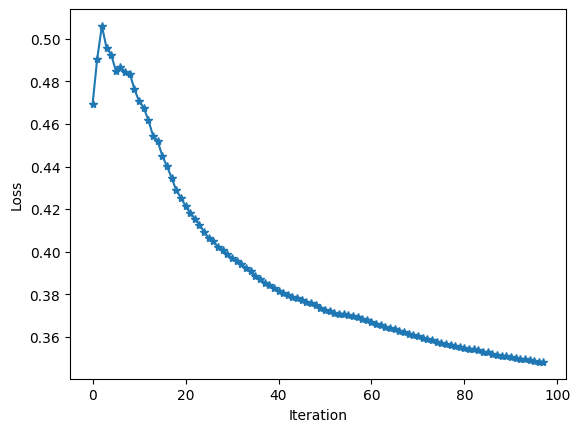

array([0.        , 0.46923655, 0.49070263, 0.50608349, 0.49581927,
       0.492551  , 0.48505947, 0.48697364, 0.48442101, 0.48369557,
       0.47637892, 0.47067678, 0.46770585, 0.46176535, 0.45457825,
       0.4519546 , 0.44502974, 0.44012842, 0.4347164 , 0.42877233,
       0.42542893, 0.42140922, 0.41816106, 0.41550589, 0.41266602,
       0.40922958, 0.40628761, 0.40477601, 0.40220317, 0.40058732,
       0.39865959, 0.39700815, 0.39573187, 0.3939898 , 0.39222738,
       0.3907201 , 0.38870728, 0.38731793, 0.38548732, 0.38451234,
       0.38312468, 0.38153541, 0.38065758, 0.37964195, 0.37864643,
       0.37804902, 0.37724727, 0.37636876, 0.37591201, 0.37496021,
       0.37336066, 0.37270653, 0.37226412, 0.37123644, 0.37089697,
       0.37071851, 0.37010804, 0.36964998, 0.36910123, 0.36848018,
       0.36791861, 0.36693612, 0.3660669 , 0.3654632 , 0.36464846,
       0.36427507, 0.36369407, 0.36267844, 0.36214679, 0.36136398,
       0.36072415, 0.36020312, 0.35960281, 0.35900506, 0.35846

In [27]:
train(encdec, batch_size = 64, n_batches=100, lr=0.001, display_freq=10, device = device)
# use n_batches=2000

### Training with Attention 

In [24]:
net_att = Transliteration_EncoderDecoder_Attention(len(eng_alpha2index), 256, len(hindi_alpha2index))

Iteration 99 Loss 0.33954760432243347


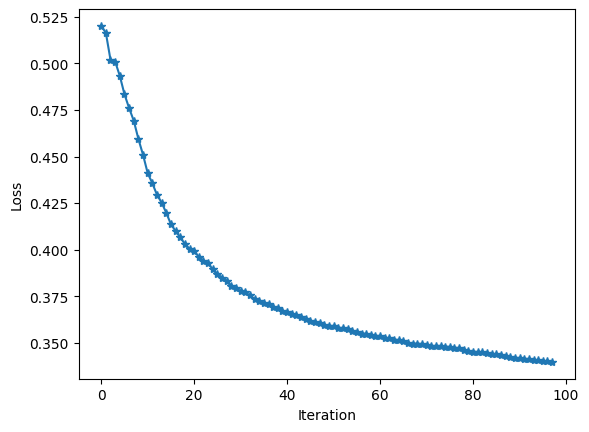

In [25]:
loss_history = train(net_att, batch_size = 64, n_batches=100, lr=0.001, display_freq=10, device = device)
# use n_batches=2000

with attention - better performance .

Extra parameters.. (+ they need to be trained.)

## Inference

In [28]:
def test(model, word, device = 'cpu'):
    model = model.eval().to(device)
    outputs = infer(model, word, 30, device)
    hindi_output = ''
    for out in outputs:
        val, indices = out.topk(1)
        index = indices.tolist()[0][0]
        if index == 0:
            break
        hindi_char = hindi_alphabets[index+1]
        hindi_output += hindi_char
    print(word + ' - ' + hindi_output)
    return hindi_output

In [31]:
def calc_accuracy(model, device = 'cpu'):
    model = model.eval().to(device)
    predictions = []
    accuracy = 0
    for i in range(len(test_data)):
        eng, hindi = test_data[i]
        gt = gt_rep(hindi, hindi_alpha2index, device)
        outputs = infer(model, eng, gt.shape[0], device)
        correct = 0
        for index, out in enumerate(outputs):
            val, indices = out.topk(1)
            hindi_pos = indices.tolist()[0]
            if hindi_pos[0] == gt[index][0]:
                correct += 1
        
        accuracy += correct/gt.shape[0]
    accuracy /= len(test_data)
    return accuracy

In [32]:
accuracy = calc_accuracy(encdec) * 100
accuracy_attn = calc_accuracy(net_att) * 100
print('Accuracy w/o attention ', accuracy)
print('Acurracy with attention', accuracy_attn)

Accuracy w/o attention  21.28541541791538
Acurracy with attention 22.48782606282606


classification - one among 129. 

(1/129) * 100 is baseline.

no batching above - first packing... then use batching.


visualise attention - visualise the alpha values - for what part of input is it giving more focus at a step.. 